In [1]:
!pip install nni

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.2/47.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 MB 26.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
  Attempting uninstall: filelock
    Found existing installation: filelock 3.17.0
    Uninstalling filelock-3.17.0:
      Successfully uninstalled filelock-3.17.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pytensor 2.26.4 requires filelock>=3.15, but you have filelock 3.11.0 which is incompatible.


In [2]:
import nni
import torch
from torchvision import transforms
from torchvision.datasets import CIFAR10
from nni.nas.evaluator.pytorch import DataLoader

import numpy as np
from nni.nas.evaluator.pytorch import Classification
from torch.utils.data import SubsetRandomSampler
from nni.nas.hub.pytorch import DARTS as DartsSpace
from nni.nas.space import model_context

import matplotlib.pyplot as plt
from IPython.display import clear_output
import graphviz
import io
from PIL import Image

from tqdm import tqdm

import json
import os
import random

/usr/local/lib/python3.10/dist-packages/nni/nas/nn/pytorch/layers.py:94: RuntimeWarning: <class 'torch.nn.parameter.Buffer'> is found to be not a nn.Module, which is unexpected. It means your PyTorch version might not be supported.
  warnings.warn(f'{obj} is found to be not a nn.Module, which is unexpected. '


In [12]:
CIFAR_MEAN = [0.49139968, 0.48215827, 0.44653124]
CIFAR_STD = [0.24703233, 0.24348505, 0.26158768]

transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(CIFAR_MEAN, CIFAR_STD),
])

train_data = nni.trace(CIFAR10)(root='./data', train=True, download=True, transform=transform)

num_samples = len(train_data)
indices = np.random.permutation(num_samples)
split = num_samples // 2

search_train_loader = DataLoader(
    train_data, batch_size=4096, num_workers=6,
    sampler=SubsetRandomSampler(indices[:split]),
)

search_valid_loader = DataLoader(
    train_data, batch_size=4096, num_workers=6,
    sampler=SubsetRandomSampler(indices[split:]),
)

Files already downloaded and verified


In [13]:
def load_arch_dicts(json_path):
    with open(json_path, 'r') as f:
        arch_dicts = json.load(f)
    return arch_dicts

arch_dicts = load_arch_dicts('/kaggle/input/model-architectures/arch_dicts.json')

In [14]:
def plot_single_cell(arch_dict, cell_name):
    g = graphviz.Digraph(
        node_attr=dict(style='filled', shape='rect', align='center'),
        format='png'
    )
    g.body.extend(['rankdir=LR'])

    g.node('c_{k-2}', fillcolor='darkseagreen2')
    g.node('c_{k-1}', fillcolor='darkseagreen2')

    max_nodes = max([int(key.split('_')[1]) for key in arch_dict.keys() if key.startswith(f'{cell_name}/op_')])

    for i in range(2, max_nodes + 1):
        g.node(str(i), fillcolor='lightblue')

    for i in range(2, max_nodes + 1):
        for j in range(2):
            op = arch_dict[f'{cell_name}/op_{i}_{j}']
            from_ = arch_dict[f'{cell_name}/input_{i}_{j}']
            
            if from_ == [0]:
                u = 'c_{k-2}'
            elif from_ == [1]:
                u = 'c_{k-1}'
            else:
                u = str(from_)
            v = str(i)
            g.edge(u, v, label=op, fillcolor='gray')

    g.node('c_{k}', fillcolor='palegoldenrod')
    for i in range(2, max_nodes + 1):
        g.edge(str(i), 'c_{k}', fillcolor='gray')

    g.attr(label=f'{cell_name.capitalize()} cell')

    image = Image.open(io.BytesIO(g.pipe()))
    return image

def plot_cells(arch_dict, cell_names):
    images = [plot_single_cell(arch_dict, cell_name) for cell_name in cell_names]
    
    height_ratio = max(image.size[1] / image.size[0] for image in images)
    
    _, axs = plt.subplots(1, len(images), figsize=(20 * len(images), 10 * height_ratio))
    
    if len(images) == 1:
        axs = [axs]
    
    for ax, image in zip(axs, images):
        ax.imshow(image)
        ax.axis('off')

    plt.show()

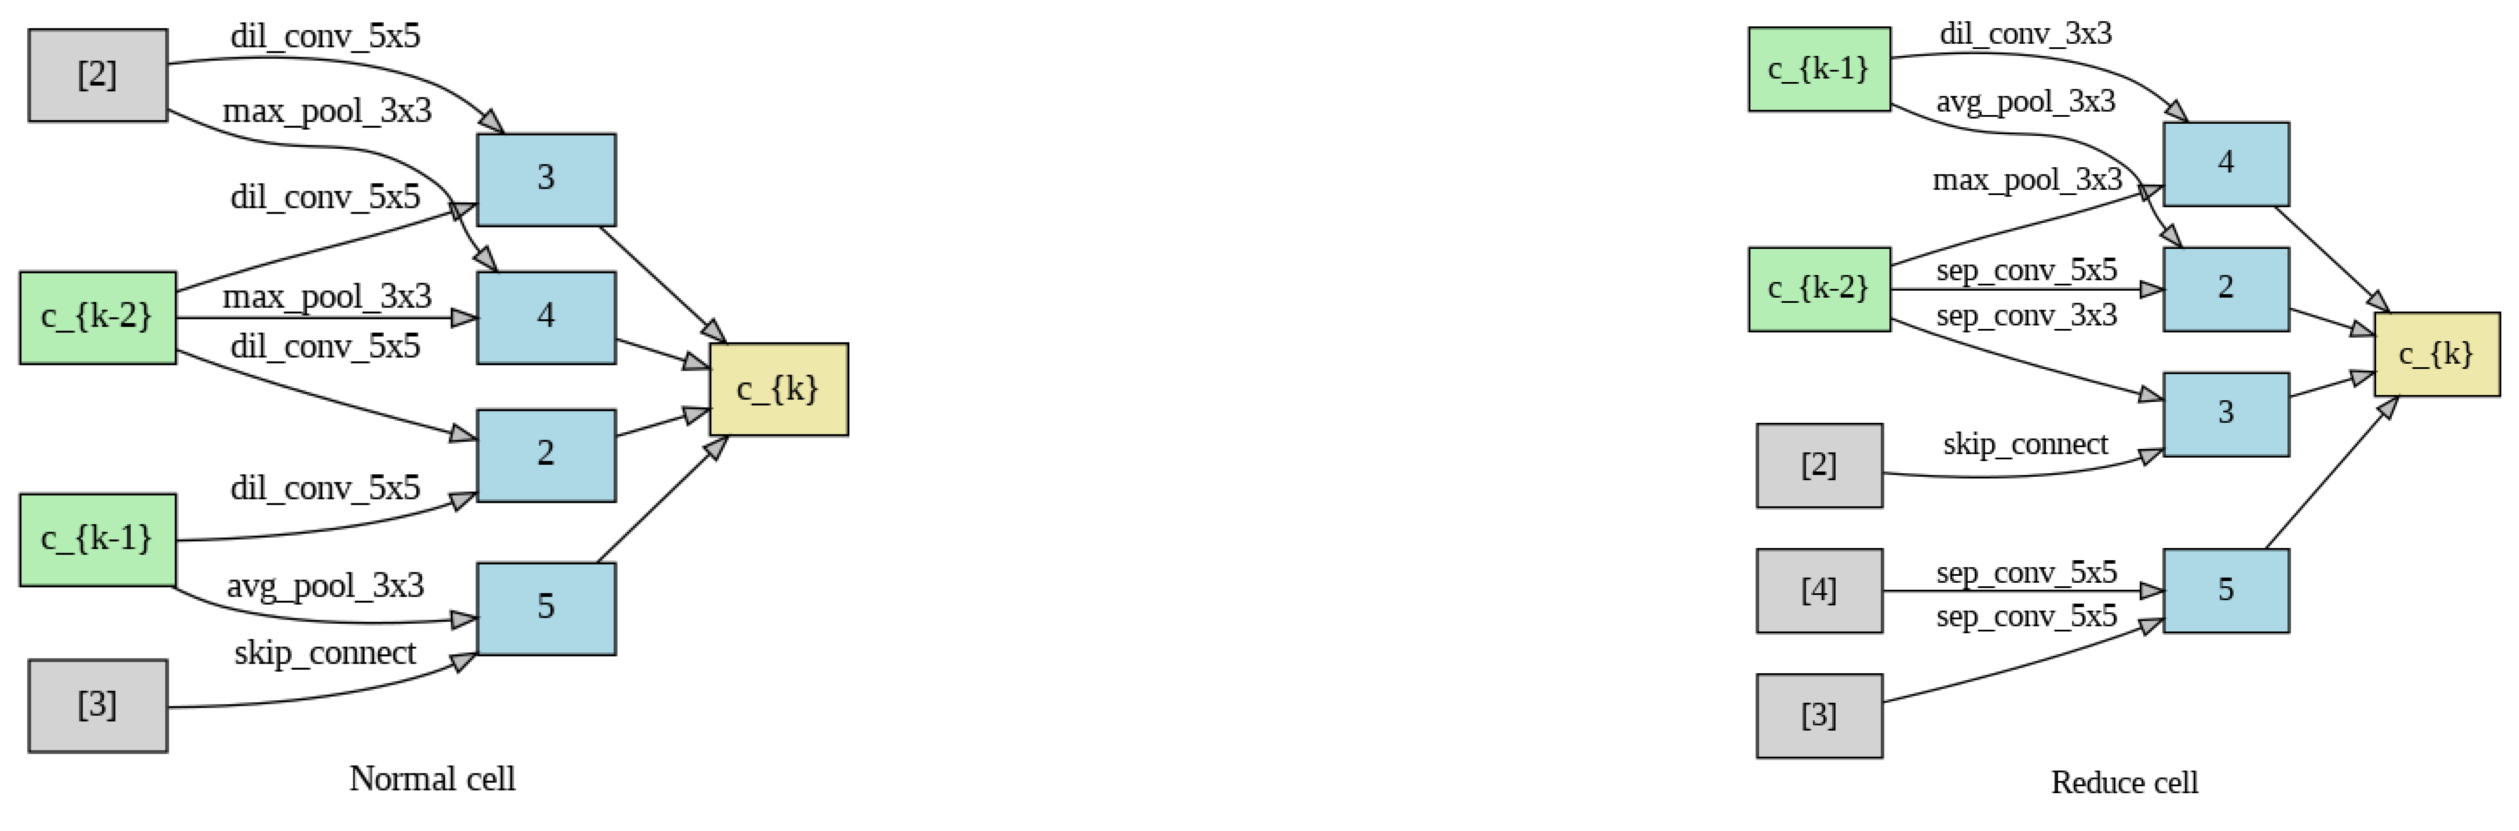

In [15]:
plot_cells(arch_dicts[420], ['normal', 'reduce'])

In [16]:
def train_model(architecture, train_loader, valid_loader, max_epochs=10, learning_rate=1e-3):
    with model_context(architecture):
        model = DartsSpace(width=16, num_cells=3, dataset='cifar')
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if torch.cuda.device_count() > 1:
        model = torch.nn.DataParallel(model)  # Enable multi-GPU training
    
    model.to(device)
    
    evaluator = Classification(
        learning_rate=learning_rate,
        weight_decay=1e-4,
        train_dataloaders=train_loader,
        val_dataloaders=valid_loader,
        max_epochs=max_epochs,
        num_classes=10,
        export_onnx=False,          # Disable ONNX export for this experiment
        fast_dev_run=False,   # Should be false for fully training
    )
    
    evaluator.fit(model)
    
    return model


In [ ]:
models = []
architectures = []
for architecture in tqdm(arch_dicts):
    model = train_model(architecture, search_train_loader, search_valid_loader, max_epochs=100)
    
    models.append(model)
    architectures.append(architecture)
    clear_output(wait=True)



  0%|          | 1/1000 [28:09<468:49:31, 1689.46s/it]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
def evaluate_and_save_results(models, architectures, batch_size=1024, num_workers=6, folder_name="results"):
    if len(models) != len(architectures):
        raise ValueError("Количество моделей и архитектур должно совпадать")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.makedirs(folder_name, exist_ok=True)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    ])
    test_dataset = CIFAR10(root="./data", train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers)

    for i, (model, architecture) in enumerate(zip(models, architectures)):
        model.to(device)
        model.eval()

        test_correct = 0
        test_total = 0
        test_preds = []

        # Оценка на тестовом датасете
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                test_preds.extend(predicted.cpu().tolist())
                test_correct += (predicted == labels).sum().item()
                test_total += labels.size(0)
        
        test_accuracy = test_correct / test_total

        result = {
            "architecture": architecture,
            "test_predictions": test_preds,
            "test_accuracy": test_accuracy
        }

        file_name = f"model_{i+1}_results.json"
        file_path = os.path.join(folder_name, file_name)

        with open(file_path, "w") as f:
            json.dump(result, f, indent=4)

        print(f"Results for model_{i + 1} saved to {file_path}")


In [ ]:
evaluate_and_save_results(models, architectures)

In [ ]:
!zip -r results.zip /kaggle/working/results

In [ ]:
def visualize_predictions(model, dataloader, cifar_classes, mean, std, num_images=9):
    """
    Отображает изображения из CIFAR-10 с предсказаниями модели.

    :param model: обученная нейросеть
    :param dataloader: DataLoader для выборки (например, valid_loader)
    :param cifar_classes: список классов CIFAR-10
    :param mean: среднее для нормализации (список из 3 значений)
    :param std: стандартное отклонение для нормализации (список из 3 значений)
    :param num_images: количество изображений для отображения (макс. 9)
    """
    model.eval()  # Переводим в режим оценки
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Переносим модель на GPU (если есть)

    valid_iter = iter(dataloader)
    model.eval()  # Переводим модель в режим оценки

    # Пропускаем случайное количество батчей
    num_skip = random.randint(0, 5)
    valid_iter = iter(dataloader)
    for _ in range(num_skip):
        next(valid_iter, None)

    batch = next(valid_iter)
    images, labels = batch

    # Прогоняем batch через модель
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    images = images.to(device)
    labels = labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)  # Получаем предсказанный класс

    # Визуализируем изображения и их предсказания
    fig, axes = plt.subplots(3, 3, figsize=(8, 8))
    axes = axes.flatten()

    # Обратное преобразование для нормализации
    mean = torch.tensor(mean).view(3, 1, 1).to(device)
    std = torch.tensor(std).view(3, 1, 1).to(device)

    for i in range(min(num_images, len(images))):
        img = images[i] * std + mean  # Де-нормализация
        img = img.permute(1, 2, 0).cpu().numpy()  # Меняем формат изображения

        axes[i].imshow(img)
        axes[i].set_title(f"Pred: {cifar_classes[preds[i]]}\nTrue: {cifar_classes[labels[i]]}")
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
# CIFAR-10 классы
CIFAR10_CLASSES = [
    "airplane", "automobile", "bird", "cat", "deer", 
    "dog", "frog", "horse", "ship", "truck"
]

visualize_predictions(models[0], search_valid_loader, CIFAR10_CLASSES, mean=CIFAR_MEAN, std=CIFAR_STD)